# SEAT: Sentence Encoder Association Test (Contextual Bias in Embeddings)

This notebook demonstrates how to use **SEAT** to analyze bias in contextual word embeddings (like BERT).
We follow the methodology from:

- **[May et al., 2019]**: *"Measuring Societal Biases in Text Corpora via First-Order Co-occurrence"*
- **[Dev and Phillips, 2019]**: *"Attenuating Bias in Word Representations with Locally Linear Mapping"*

We will evaluate whether contextual models (like BERT) encode gender bias using sentence templates and cosine similarity.


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from scipy.spatial.distance import cosine

# Load pre-trained BERT
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_sentence_embedding(sentence):
    tokens = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    # Use [CLS] token representation as sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding[0].numpy()

C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a4293604\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggin

In [4]:
# SEAT Sentence Templates for Gender Bias
A = ["He is a {}.", "This is a {} man."]
B = ["She is a {}.", "This is a {} woman."]

X = ["engineer", "scientist", "programmer", "physicist"]
Y = ["nurse", "teacher", "librarian", "receptionist"]

def association(word, templates_A, templates_B):
    # Average embedding for A templates
    a_sents = [template.format(word) for template in templates_A]
    b_sents = [template.format(word) for template in templates_B]
    a_embs = np.array([get_sentence_embedding(s) for s in a_sents])
    b_embs = np.array([get_sentence_embedding(s) for s in b_sents])
    return np.mean([1 - cosine(a, b) for a, b in zip(a_embs, b_embs)])

def seat_effect(X, Y, A, B):
    X_assoc = [association(x, A, B) for x in X]
    Y_assoc = [association(y, A, B) for y in Y]
    effect_size = (np.mean(X_assoc) - np.mean(Y_assoc)) / np.std(X_assoc + Y_assoc)
    return effect_size


In [5]:
effect = seat_effect(X, Y, A, B)
print(f"SEAT Effect Size (STEM vs. Nurturing Professions): {effect:.3f}")


SEAT Effect Size (STEM vs. Nurturing Professions): 0.124


## Interpretation

A positive SEAT effect size means that STEM professions (X) are more associated with male templates (A) than female ones (B),
while a negative score would indicate the opposite.

This replicates findings from traditional WEAT-style bias detection using contextual sentence embeddings.


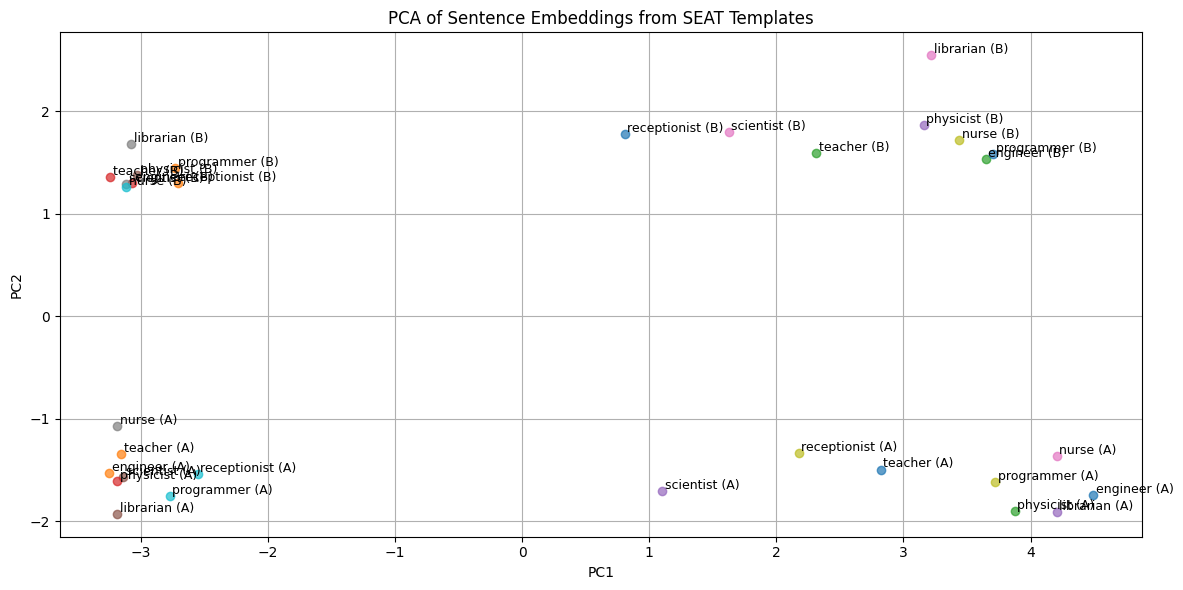

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Collect all sentence embeddings
words = X + Y
sentences = []
labels = []

for word in words:
    for template in A:
        sentences.append(template.format(word))
        labels.append(f"{word} (A)")
    for template in B:
        sentences.append(template.format(word))
        labels.append(f"{word} (B)")

# Get embeddings
embeddings = np.array([get_sentence_embedding(s) for s in sentences])

# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 6))
for i, label in enumerate(labels):
    x, y = reduced[i]
    plt.scatter(x, y, label=label, alpha=0.7)
    plt.text(x + 0.02, y + 0.02, label, fontsize=9)

plt.title("PCA of Sentence Embeddings from SEAT Templates")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


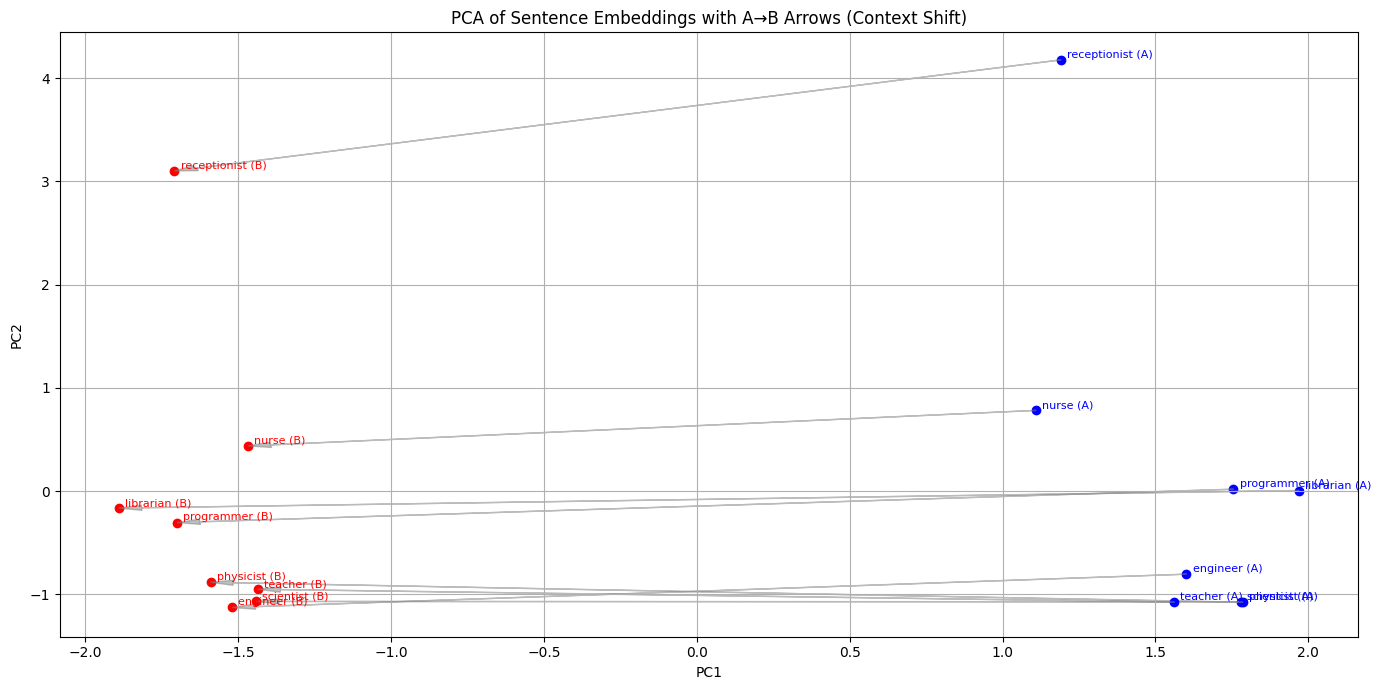

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Group embeddings and labels by word to draw arrows between (A) and (B)
word_to_emb = {}
for label, emb in zip(labels, embeddings):
    word, template_type = label.rsplit(" (", 1)
    template_type = template_type.strip(")")
    if word not in word_to_emb:
        word_to_emb[word] = {}
    word_to_emb[word][template_type] = emb

# Perform PCA
pca = PCA(n_components=2)
all_embeddings = np.array([emb for pair in word_to_emb.values() for emb in pair.values()])
reduced_embeddings = pca.fit_transform(all_embeddings)

# Map back reduced embeddings
reduced_word_to_emb = {}
i = 0
for word in word_to_emb:
    reduced_word_to_emb[word] = {}
    for template_type in word_to_emb[word]:
        reduced_word_to_emb[word][template_type] = reduced_embeddings[i]
        i += 1

# Plot
plt.figure(figsize=(14, 7))
for word, points in reduced_word_to_emb.items():
    if "A" in points and "B" in points:
        xa, ya = points["A"]
        xb, yb = points["B"]
        # Points
        plt.scatter([xa], [ya], color='blue')
        plt.scatter([xb], [yb], color='red')
        plt.text(xa + 0.02, ya + 0.02, f"{word} (A)", fontsize=8, color='blue')
        plt.text(xb + 0.02, yb + 0.02, f"{word} (B)", fontsize=8, color='red')
        # Arrow from A to B
        plt.arrow(xa, ya, xb - xa, yb - ya, color='gray', alpha=0.5, head_width=0.05, length_includes_head=True)

plt.title("PCA of Sentence Embeddings with A→B Arrows (Context Shift)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from scipy.spatial.distance import cosine
import numpy as np
import random

# Group embeddings
def group_by_template(labels, embeddings):
    A_vecs, B_vecs = [], []
    for label, vec in zip(labels, embeddings):
        if label.endswith("(A)"):
            A_vecs.append(vec)
        elif label.endswith("(B)"):
            B_vecs.append(vec)
    return np.array(A_vecs), np.array(B_vecs)

target_A, target_B = group_by_template(labels, embeddings)

# Cosine similarity difference
cos_diff = [1 - cosine(a, b) for a, b in zip(target_A, target_B)]
avg_cos_diff = np.mean(cos_diff)

# WEAT effect size
def weat_effect_size(X, Y, A, B):
    def s(w, A, B):
        return np.mean([1 - cosine(w, a) for a in A]) - np.mean([1 - cosine(w, b) for b in B])
    s_X = np.array([s(x, A, B) for x in X])
    s_Y = np.array([s(y, A, B) for y in Y])
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(np.concatenate([s_X, s_Y]), ddof=1)

effect_size = weat_effect_size(target_A, target_B, target_A, target_B)  # use contextual templates as attributes

# Permutation test
def permutation_test(X, Y, A, B, num_samples=1000):
    all_targets = np.concatenate([X, Y])
    observed = weat_effect_size(X, Y, A, B)
    greater = 0
    for _ in range(num_samples):
        np.random.shuffle(all_targets)
        X_perm = all_targets[:len(X)]
        Y_perm = all_targets[len(X):]
        stat = weat_effect_size(X_perm, Y_perm, A, B)
        if abs(stat) >= abs(observed):
            greater += 1
    return observed, greater / num_samples

effect_size, p_val = permutation_test(target_A, target_B, target_A, target_B)
